44100


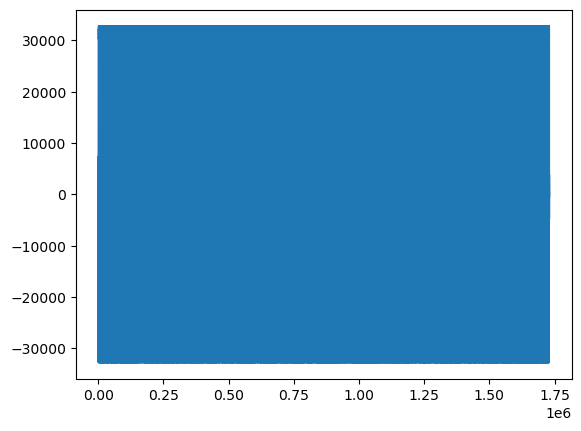

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [110]:
# This code intents to show how to use pydub to read m4a file
# And transform it to a numpy array
from pydub import AudioSegment
from pydub.utils import mediainfo
import matplotlib.pyplot as plt
import numpy as np
import cv2 
path = "/home/casper/EK2370/data_cots/Range_Test_File.m4a"

# Read m4a file
audio = AudioSegment.from_file(path, format="m4a")


# Get the different channels 
audio_channels = audio.split_to_mono()
audio_array = []
for channel in audio_channels:
    audio_array.append(channel.get_array_of_samples().tolist())
audio_array = np.array(audio_array)

fs = int(mediainfo(path)['sample_rate'])
print(fs)
data = audio_array[0,:]
sync= audio_array[1,:]


# Plot arr1 
plt.plot(sync)
plt.show()
plt.figure()

In [111]:
# Constants
c = 3e8;                # speed of light [m/s]
Ts = 1/fs;              # sampling time [s]
Tp = 0.02;              # pulse width [s]
fc = 2.43e9;            # center frequency [hz]
Nsamples = int(Tp*fs);       # number of samples per puls
BW = 2.495e9 - 2.408e9; # bandwidth of FMCW [Hz]

# Print all the constants
print("c: ", c)
print("Ts: ", Ts)
print("Tp: ", Tp)
print("fc: ", fc)
print("Nsamples: ", Nsamples)
print("BW: ", BW)


c:  300000000.0
Ts:  2.2675736961451248e-05
Tp:  0.02
fc:  2430000000.0
Nsamples:  882
BW:  87000000.0


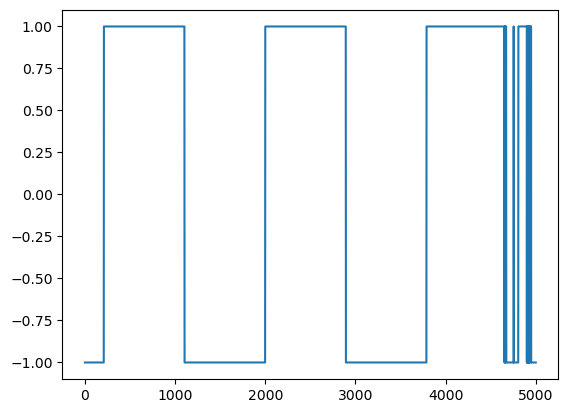

[   1317    3147    4978    6808    8638   10468   12298   14128   15958
   17788   19618   21448   23278   25108   26937   28767   30597   32427
   34257   36087   37916   39746   41576   43405   45235   47064   48894
   50723   52553   54382   56212   58041   59871   61700   63530   65330
   65359   67189   69018   70848   72677   74507   76336   78166   79995
   81825   83654   85484   87314   89143   90973   92802   94632   96461
   98291  100120  101949  103779  105608  107437  109267  111096  112925
  114755  116584  118413  120243  122072  123901  125730  127560  129389
  131218  133047  134876  136705  138534  140363  142193  144022  145851
  147680  149509  151338  153167  154996  156825  158653  160482  162311
  164139  165968  167796  169625  171453  173281  175110  176938  178766
  180594  182422  184249  186077  187905  189732  191560  193387  195214
  197042  198869  200696  202523  204350  206177  208003  209830  211657
  213484  215310  217136  218963  220789  222615  2

In [112]:
# Extract upchirp index
chirp = np.zeros_like(sync)
chirp[sync > 0] = 1

chirp[sync < 0] = -1
# Plot chirp
plt.plot(chirp[-5000:])
plt.show()
# Find zero crossing indecies
zero_crossings = np.where(np.diff(np.sign(chirp)))[0]
# Save all zero crossing that have an even index
upchirp_indicies = zero_crossings[0::2] # Even index
upchirp_indicies = upchirp_indicies[1:] # Remove first index since it is not a full chirp
M = len(upchirp_indicies) # Number of chirps
print(upchirp_indicies)

# Transform upchirp indecies to int
upchirp_indicies = upchirp_indicies.astype(int)



## Parsing up-chirp

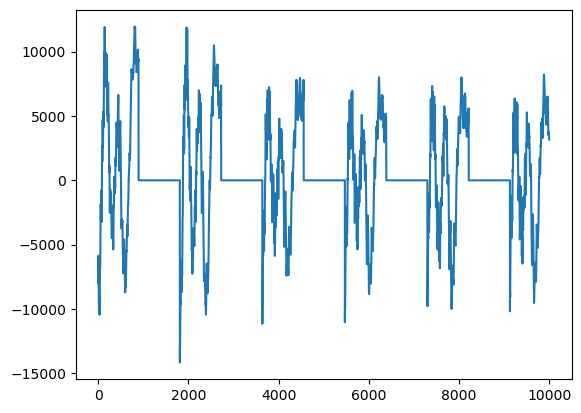

In [113]:
# Data inversion, only keep the up chirp
up_chirp_mask = np.zeros_like(sync)
up_chirp_mask[sync > 0] = 1

upchirp_data = -data*up_chirp_mask
# Plot upchirp data
plt.plot(upchirp_data[5000:15000])
plt.show()



## Creating image

In [114]:
M

973

973
(973, 882)
882
(1729536,)
973
(973, 882)


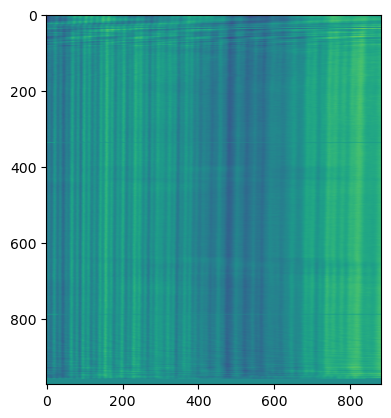

In [115]:
# Create a matrix with all the chirps in the data set, each row is a chirp
upchirp_matrix = np.zeros((M, Nsamples))
print(upchirp_indicies.size)
print(upchirp_matrix.shape)
print(Nsamples)
print(upchirp_data.shape)
print(len(upchirp_indicies))
for m in range(M):
    start = upchirp_indicies[m]
    end = upchirp_indicies[m]+Nsamples
    # If error is thrown, break
    if end > len(upchirp_data):
        break
    upchirp_matrix[m,:end-start] = upchirp_data[start:end]
# Print the upchirp matrix shape
print(upchirp_matrix.shape)
# Plot the upchirp matrix
plt.imshow(upchirp_matrix)
plt.show()



    

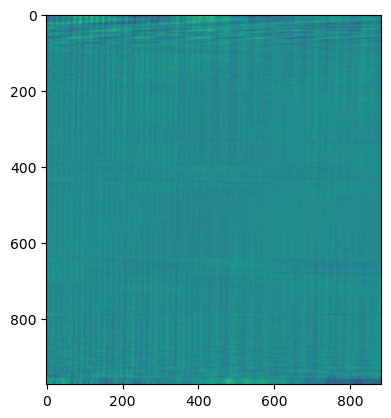

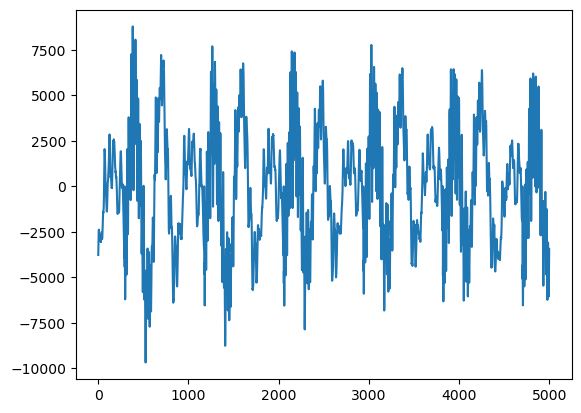

In [116]:
# MS clutter rejection
## Mean of each column
mean = np.mean(upchirp_matrix, axis=0)
## Subtract mean from each column
upchirp_matrix = upchirp_matrix - mean
## Plot the upchirp matrix
plt.imshow(upchirp_matrix)
plt.show()

# Plot and flatten the upchirp matrix
plt.plot(upchirp_matrix.flatten()[5000:10000])
plt.show()


![Alt text](image.png)

In [117]:
# MTI clutter rejection

## 1 pulse MTI (orginal data)
S = upchirp_matrix

## 2 pulse MTI
### Subtract the previous chirp(row) from the current chirp (row)
S_2pulse = np.zeros_like(upchirp_matrix)
S_2pulse[1:,:] = upchirp_matrix[1:,:] - upchirp_matrix[:-1,:] 

## 3 pulse MTI
S_3pulse = np.zeros_like(upchirp_matrix)
S_3pulse[2:,:] = upchirp_matrix[2:,:] - 2*upchirp_matrix[1:-1,:] + upchirp_matrix[:-2,:]

Now we have 
* ``S = upchirp_matrix`` which we have peformed MS clutter rejection on
* ``S_2pulse`` which we have peformed 2 pulse MTI on
* ``S_3pulse``which we have peformed 3 pulse MTI on 

![Alt text](image-1.png)

/tmp/ipykernel_41066/553486594.py:13: RuntimeWarning: divide by zero encountered in log
  S_2pulse_ifft_abs_log = np.log(S_2pulse_ifft_abs)
/tmp/ipykernel_41066/553486594.py:14: RuntimeWarning: divide by zero encountered in log
  S_3pulse_ifft_abs_log = np.log(S_3pulse_ifft_abs)


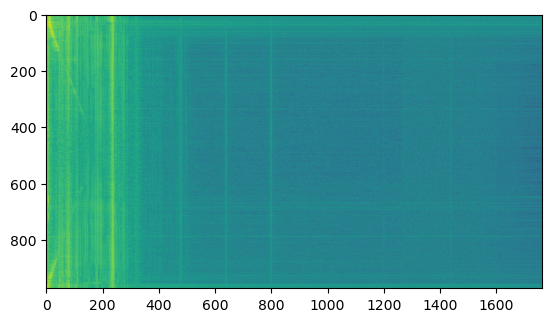

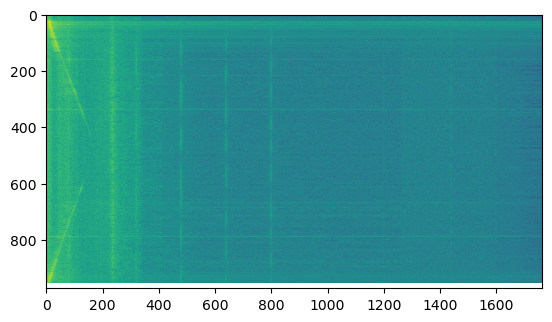

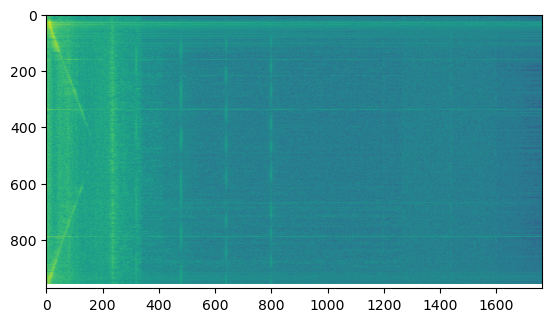

In [124]:
# Do IFFT on the upchirp matrix and the MTI matrices
S_ifft = np.fft.ifft(S, axis=1, n=4*Nsamples)
S_2pulse_ifft = np.fft.fft(S_2pulse, axis=1,n=4*Nsamples)
S_3pulse_ifft = np.fft.fft(S_3pulse, axis=1,n=4*Nsamples)

# Take the absolute value of the ifft
S_ifft_abs = np.abs(S_ifft)
S_2pulse_ifft_abs = np.abs(S_2pulse_ifft)
S_3pulse_ifft_abs = np.abs(S_3pulse_ifft)

# Take the log of the absolute value
S_ifft_abs_log = np.log(S_ifft_abs)
S_2pulse_ifft_abs_log = np.log(S_2pulse_ifft_abs)
S_3pulse_ifft_abs_log = np.log(S_3pulse_ifft_abs)

# Cut out the first 2*Nsamples
S_ifft_abs_log = S_ifft_abs_log[:,:2*Nsamples]
S_2pulse_ifft_abs_log = S_2pulse_ifft_abs_log[:,:2*Nsamples]
S_3pulse_ifft_abs_log = S_3pulse_ifft_abs_log[:,:2*Nsamples]







# Plot the data
plt.imshow(S_ifft_abs_log)
plt.show()
plt.imshow(S_2pulse_ifft_abs_log)
plt.show()
plt.imshow(S_3pulse_ifft_abs_log)
plt.show()


